In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import xobjects as xo
import xtrack as xt
import xfields as xf
import xpart as xp
import pickle
import scipy.stats as stats

# Generating sequences

context = xo.ContextCpu()

p0c = 6500e9
bunch_intensity = 0.7825E12
physemit_x = (2.946E-6*xp.PROTON_MASS_EV)/p0c 
physemit_y = (2.946E-6*xp.PROTON_MASS_EV)/p0c 
beta_x = 19.17
beta_y = 19.17
sigma_z = 0.08
sigma_delta = 1E-4
beta_s = sigma_z/sigma_delta
Qx = 62.31
Qy = 60.32
Qs = 2.1E-3
frev = 11245.5 
nTurn = 1000
sigma = np.sqrt(physemit_x*beta_x)

n_macroparticles = int(1000)
shifts = [0]


particles_b1 = xp.Particles(_context=context,
    p0c=p0c,
    x=np.sqrt(physemit_x*beta_x)*(np.random.randn(n_macroparticles)),
    px=np.sqrt(physemit_x/beta_x)*np.random.randn(n_macroparticles),
    y=-np.sqrt(physemit_y*beta_y)*(np.random.randn(n_macroparticles)),
    py=np.sqrt(physemit_y/beta_y)*np.random.randn(n_macroparticles),
    zeta=sigma_z*np.random.randn(n_macroparticles),
    delta=sigma_delta*np.random.randn(n_macroparticles),
    weight=bunch_intensity/n_macroparticles
)
particles_on_bb = particles_b1.copy()
particles_off_bb = particles_b1.copy()
particles_on_nbb = particles_b1.copy()
particles_off_nbb = particles_b1.copy()


def scatter_hist(x, y, ax, ax_histx, ax_histy, mu, sigma):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 1e-6
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')
    t = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    ax_histx.plot(t, stats.norm.pdf(t, mu, sigma)*n_macroparticles*binwidth)
    ax_histy.plot(stats.norm.pdf(t, mu, sigma)*n_macroparticles*binwidth, t)

for coupstate in ['on_bb','off_bb', 'on_nbb', 'off_nbb']:
    for i in range(len(shifts)):
        xs_b1 = []
        ys_b1 = []
        xs_b2 = []
        ys_b2 = []
        pxs_b1 = []
        pys_b1 = []
        pxs_b2 = []
        pys_b2 = []

        #############
        # Beam-beam #
        #############
        slicer = xf.TempSlicer(sigma_z=sigma_z, n_slices=1, mode = 'shatilov')

        bbeam = xf.BeamBeamBiGaussian2D(_context=context,
                                            other_beam_q0=particles_b1.q0,
                                            other_beam_beta0=particles_b1.beta0[0],
                                            other_beam_num_particles=bunch_intensity,
                                            other_beam_Sigma_11=physemit_x * beta_x,
                                            other_beam_Sigma_33=physemit_y * beta_y,
                                            ref_shift_x= 0*np.sqrt(physemit_x * beta_x),
                                            ref_shift_y= 0*np.sqrt(physemit_y * beta_y))


        #################################################################
        # arcs (here they are all the same with half the phase advance) #
        #################################################################

        arc = xt.LineSegmentMap(
                betx = beta_x,bety = beta_y,
                qx = Qx, qy = Qy,bets = beta_s, qs=Qs)
        quad = xt.Quadrupole(k1 = 0, k1s = 0.2622, length = 0.01)
    #################################################################
        # Tracker                                                       #
        #################################################################
        if coupstate == 'on_bb':
            elements_b1 = [bbeam,arc, quad]
            element_names_b1 = ['bbeam_b1','arc', 'quad']
            particles = particles_on_bb
            label = "Coupling and Beam-beam"
        if coupstate == 'off_bb':
            elements_b1 = [bbeam,arc]
            element_names_b1 = ['bbeam_b1', 'arc']
            particles = particles_off_bb
            label = "Beam-beam"
        if coupstate == 'on_nbb':
            elements_b1 = [arc, quad]
            element_names_b1 = ['arc', 'quad']
            particles = particles_on_nbb
            label = "Coupling"
        if coupstate == 'off_nbb':
            elements_b1 = [arc]
            element_names_b1 = ['arc']
            particles = particles_off_nbb
            label = "No effects"
        line_b1 = xt.Line(elements=elements_b1, element_names=element_names_b1)
        monitor_bbeam_b1 = xt.BeamSizeMonitor(start_at_turn=nTurn, stop_at_turn=nTurn)       
        line_b1.insert_element(index='arc', element=monitor_bbeam_b1, name='mon_b1')
        line_b1.build_tracker()
        #################################################################
        # Tracking                                                      #
        #################################################################

        line_b1.track(particles,num_turns=nTurn,turn_by_turn_monitor=True)
        xs_b1.append(line_b1.record_last_track.x)
        ys_b1.append(line_b1.record_last_track.y)

        pxs_b1.append(line_b1.record_last_track.px)
        pys_b1.append(line_b1.record_last_track.py)

        line_b1.discard_tracker()


        #fig1, ax1 = plt.subplots()
        #fig3, ax3 = plt.subplots()
        #fig4, ax4 = plt.subplots()
        #sigma = np.sqrt(physemit_x*beta_x)
        #sigma_p = np.sqrt(physemit_x/beta_x)
        #ax1.set_title(f"X phase space with {label}")
        #ax1.set_xlabel("x")
        #ax1.set_ylabel("px")
        #ax3.set_title(f"Y phase space with {label}")
        #ax3.set_xlabel("y")
        #ax3.set_ylabel("py")
        #ax4.set_title(f"XY  space with {label}")
        #ax4.set_xlabel("x")
        #ax4.set_ylabel("y")

        #ax1.set_xlim(-8, 8)
        #ax1.set_ylim(-8, 8)
        #ax3.set_xlim(-8, 8)
        #ax3.set_ylim(-8, 8)
        #ax4.set_xlim(-8, 8)
        #ax4.set_ylim(-8, 8)

        print(xs_b1[i].shape)
        # Create a colormap
        cmap = plt.get_cmap('brg')
        # Generate colors from the colormap
        colors = [cmap(k / n_macroparticles) for k in range(n_macroparticles)]
        #for j in range(n_macroparticles):
        #    ax1.plot(xs_b1[i][j,:]/sigma, pxs_b1[i][j,:]/sigma_p, '.', color = colors[j], markersize = 0.2)  
        #    ax3.plot(ys_b1[i][j,:]/sigma, pys_b1[i][j,:]/sigma_p, '.', color = colors[j], markersize = 0.2)
        #    ax4.plot(xs_b1[i][j,:]/sigma, ys_b1[i][j,:]/sigma, '.', color = colors[j], markersize = 0.2)
        fig = plt.figure(layout='constrained')
        fig.suptitle("%.2f shift in y")
        #Create the main axes, leaving 25% of the figure space at the top and on the
        # right to position marginals.
        ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
        # The main axes' aspect can be fixed.
        ax.set(aspect=1)
         # Create marginal axes, which have 25% of the size of the main axes.  Note that
         # the inset axes are positioned *outside* (on the right and the top) of the
         # main axes, by specifying axes coordinates greater than 1.  Axes coordinates
         # less than 0 would likewise specify positions on the left and the bottom of
         # the main axes.
        ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
        ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
        # Draw the scatter plot and marginals.
        scatter_hist(xs_b1[-1], ys_b1[-1], ax, ax_histx, ax_histy, mu = 0, sigma = sigma)


        plt.show()

<class 'float'>


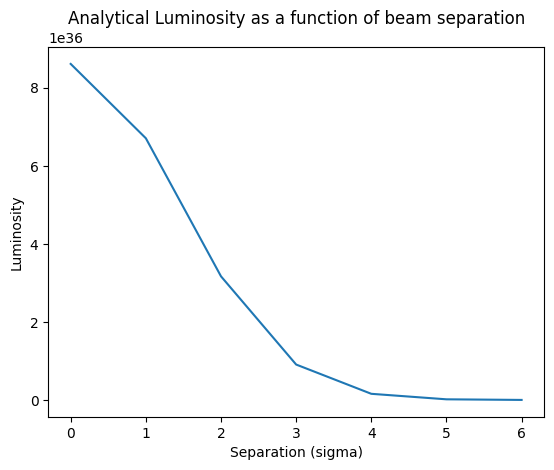

In [1]:
#L0 analytical
import numpy as np
import matplotlib.pyplot as plt
import xpart as xp

lumis = []
separation = [0, 1, 2, 3, 4, 5, 6]

p0c = 7e12
n_macroparticles = int(1.2e4)
bunch_intensity = 7.8e10
physemit_x = (2.95E-6*xp.PROTON_MASS_EV)/p0c
physemit_y = (2.95E-6*xp.PROTON_MASS_EV)/p0c
beta_x = 19.2
beta_y = 19.2
frev = 11245.5 
print(type(physemit_x))

def Lumi_analytical(Nb, N1, N2, frev, Delta_i, sig_i, sig_x, sig_y):
    W = np.exp(-Delta_i**2/(4*sig_i**2))
    return ((Nb * N1 * N2 * frev * W)/(4*np.pi*sig_x * sig_y))

for i in range(len(separation)):
    lumis.append(Lumi_analytical(n_macroparticles, bunch_intensity, bunch_intensity, frev, separation[i]*np.sqrt(physemit_x*beta_x),np.sqrt(physemit_x*beta_x), np.sqrt(physemit_x*beta_x), np.sqrt(physemit_x*beta_x)))
plt.plot(separation, lumis)
plt.title("Analytical Luminosity as a function of beam separation")
plt.xlabel("Separation (sigma)")
plt.ylabel("Luminosity")
plt.show()

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import xobjects as xo
import xtrack as xt
import xfields as xf
import xpart as xp
import pickle

context = xo.ContextCpu()

p0c = 7e12
n_macroparticles = int(1e4)
bunch_intensity = 1.15e11
physemit_x = (3.75E-6*xp.PROTON_MASS_EV)/p0c 
physemit_y = (3.75E-6*xp.PROTON_MASS_EV)/p0c 
beta_x = 0.55
beta_y = 0.55
sigma_z = 0.08
sigma_delta = 1E-4
beta_s = sigma_z/sigma_delta
Qx = 62.31
Qy = 60.32
Qs = 2.1E-3
frev = 11245.5 
nTurn = 1024

separation = [0, 1, 2, 3, 4, 5, 6]
frev = 11245.5 
lumi_analytical = []
lumi_averages_beambeam_x = []
lumi_averages_nobeambeam_x = []
lumi_averages_beambeam_y = []
lumi_averages_nobeambeam_y = []
lumi_averages_beambeam_xy = []
lumi_averages_nobeambeam_xy = []

def Lumi_analytical(Nb, N1, N2, frev, Delta_i, sig_i, sig_x, sig_y):
    W = np.exp(-Delta_i**2/(4*sig_i**2))
    return ((Nb * N1 * N2 * frev * W)/(4 * np.pi * sig_x * sig_y))

for shift in separation:
    lumi_analytical.append(Lumi_analytical(1, bunch_intensity, bunch_intensity, frev, shift*np.sqrt(physemit_x*beta_x),np.sqrt(physemit_x*beta_x), np.sqrt(physemit_x*beta_x), np.sqrt(physemit_y*beta_x)))

    xshift_file_name = '/Users/chenying/xsuite_dev/lumianalysis/xshift_'+str(shift)+'.pkl'
    yshift_file_name = '/Users/chenying/xsuite_dev/lumianalysis/yshift_'+str(shift)+'.pkl'
    xyshift_file_name = '/Users/chenying/xsuite_dev/lumianalysis/xyshift_'+str(shift)+'.pkl'
    
    nbb_xshift_file_name = '/Users/chenying/xsuite_dev/lumianalysis/nbb_xshift_'+str(shift)+'.pkl'
    nbb_yshift_file_name = '/Users/chenying/xsuite_dev/lumianalysis/nbb_yshift_'+str(shift)+'.pkl'
    nbb_xyshift_file_name = '/Users/chenying/xsuite_dev/lumianalysis/nbb_xyshift_'+str(shift)+'.pkl'

# Open the file for reading
    with open(xshift_file_name, 'rb') as xfile:
    # Load the data from the file
        x_data_loaded = pickle.load(xfile)
        
    with open(yshift_file_name, 'rb') as yfile:
    # Load the data from the file
        y_data_loaded = pickle.load(yfile)
    
    with open(xyshift_file_name, 'rb') as xyfile:
    # Load the data from the file
        xy_data_loaded = pickle.load(xyfile)
        
    with open(nbb_xshift_file_name, 'rb') as nbb_xfile:
    # Load the data from the file
        nbb_x_data_loaded = pickle.load(nbb_xfile)
        
    with open(nbb_yshift_file_name, 'rb') as nbb_yfile:
    # Load the data from the file
        nbb_y_data_loaded = pickle.load(nbb_yfile)
    
    with open(nbb_xyshift_file_name, 'rb') as nbb_xyfile:
    # Load the data from the file
        nbb_xy_data_loaded = pickle.load(nbb_xyfile)
        
    lumi_averages_beambeam_x.append(np.mean(x_data_loaded['luminosity_values'][200:]))
    lumi_averages_nobeambeam_x.append(np.mean(nbb_x_data_loaded['luminosity_values'][200:]))
    lumi_averages_beambeam_y.append(np.mean(y_data_loaded['luminosity_values'][200:]))
    lumi_averages_nobeambeam_y.append(np.mean(nbb_y_data_loaded['luminosity_values'][200:]))
    lumi_averages_beambeam_xy.append(np.mean(xy_data_loaded['luminosity_values'][200:]))
    lumi_averages_nobeambeam_xy.append(np.mean(nbb_xy_data_loaded['luminosity_values'][200:]))

fig0, ax0 = plt.subplots()
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
fig5, ax5 = plt.subplots()


ax0.set_title("Luminosity as a function of beam separation - x direction")
ax0.set_xlabel("Separation in x (sigma)")
ax0.set_ylabel("Luminosity")
ax0.plot(separation, (frev*np.array(lumi_averages_beambeam_x)), label = "With beam beam")
ax0.plot(separation, (frev*np.array(lumi_averages_nobeambeam_x)), label = "Without beam beam")
ax0.plot(separation, (np.array(lumi_analytical)), label = "Analytical")
ax0.legend()

ax1.set_title("Luminosity as a function of beam separation - y direction")
ax1.set_xlabel("Separation in y (sigma)")
ax1.set_ylabel("Luminosity")
ax1.plot(separation, (frev*np.array(lumi_averages_beambeam_y)), label = "With beam beam")
ax1.plot(separation, (frev*np.array(lumi_averages_nobeambeam_y)), label = "Without beam beam")
ax1.plot(separation, (np.array(lumi_analytical)), label = "Analytical")
ax1.legend()

ax2.set_title("Luminosity as a function of beam separation - xy direction")
ax2.set_xlabel("Separation in xy (sigma)")
ax2.set_ylabel("Luminosity")
ax2.plot(separation, (frev*np.array(lumi_averages_beambeam_xy)), label = "With beam beam")
ax2.plot(separation, (frev*np.array(lumi_averages_nobeambeam_xy)), label = "Without beam beam")
ax2.plot(separation, (np.array(lumi_analytical)), label = "Analytical")
ax2.legend()

ax3.set_title("Luminosity bias (L/L0) as a function of beam separation - x direction")
ax3.set_xlabel("Separation in x (sigma)")
ax3.set_ylabel("Luminosity bias (L/L0 - %)")
ax3.plot(separation, (frev*np.array(lumi_averages_beambeam_x)-np.array(lumi_analytical))/np.array(lumi_analytical), label = "Numerical")
ax3.plot(separation, (np.array(lumi_averages_beambeam_x)-np.array(lumi_averages_nobeambeam_x))/np.array(lumi_averages_nobeambeam_x), label = "Analytical")
ax3.legend()

ax4.set_title("Luminosity bias (L/L0) as a function of beam separation - y direction")
ax4.set_xlabel("Separation in y (sigma)")
ax4.set_ylabel("Luminosity bias (L/L0 - %)")
ax4.plot(separation, (frev*np.array(lumi_averages_beambeam_y)-np.array(lumi_analytical))/np.array(lumi_analytical), label = "Numerical")
ax4.plot(separation, (np.array(lumi_averages_beambeam_y)-np.array(lumi_averages_nobeambeam_y))/np.array(lumi_averages_nobeambeam_y), label = "Analytical")
ax4.legend()

ax5.set_title("Luminosity bias (L/L0) as a function of beam separation - xy direction")
ax5.set_xlabel("Separation in xy (sigma)")
ax5.set_ylabel("Luminosity bias (L/L0 - %)")
ax5.plot(separation, (frev*np.array(lumi_averages_beambeam_xy)-np.array(lumi_analytical))/np.array(lumi_analytical), label = "Numerical")
ax5.plot(separation, (np.array(lumi_averages_beambeam_xy)-np.array(lumi_averages_nobeambeam_xy))/np.array(lumi_averages_nobeambeam_xy), label = "Analytical")
ax5.legend()

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/chenying/xsuite_dev/lumianalysis/xshift_0.pkl'